### Team 3
#### Waether Forecasting

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, r2_score

Since we can't include all 32 features, we will try to see which features are most important

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

df = pd.read_csv("../data/Cairo-Weather.csv")
df = df.tail(500)
df_cleaned = df.drop(columns=[col for col in df.columns if '_min' in col or '_max' in col])

# Drop non-numeric or non-predictive columns
X_wind = df_cleaned.drop(columns=[
    'time',  
    'temperature_2m_mean (°C)', 'apparent_temperature_mean (°C)',
    'precipitation_sum (mm)', 'rain_sum (mm)',
    'sunrise (iso8601)','sunset (iso8601)',
    'wind_speed_10m_mean (km/h)', 'wind_gusts_10m_mean (km/h)'
])


Y_wind = df[['temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'wind_speed_10m_mean (km/h)']]


In [8]:
model = RandomForestRegressor()
model.fit(X_wind, Y_wind['temperature_2m_mean (°C)'])

importances = model.feature_importances_
temp_features = pd.Series(importances, index=X_wind.columns).sort_values(ascending=False).head(5).index
print(temp_features)

model.fit(X_wind, Y_wind['precipitation_sum (mm)'])

importances = model.feature_importances_
percipitation_features = pd.Series(importances, index=X_wind.columns).sort_values(ascending=False).head(5).index
print(percipitation_features)

model.fit(X_wind, Y_wind['wind_speed_10m_mean (km/h)'])

importances = model.feature_importances_
wind_features = pd.Series(importances, index=X_wind.columns).sort_values(ascending=False).head(5).index
print(wind_features)

Index(['et0_fao_evapotranspiration (mm)', 'dew_point_2m_mean (°C)',
       'relative_humidity_2m_mean (%)', 'daylight_duration (s)',
       'shortwave_radiation_sum (MJ/m²)'],
      dtype='object')
Index(['weather_code (wmo code)', 'et0_fao_evapotranspiration (mm)',
       'precipitation_hours (h)', 'relative_humidity_2m_mean (%)',
       'shortwave_radiation_sum (MJ/m²)'],
      dtype='object')
Index(['et0_fao_evapotranspiration (mm)', 'relative_humidity_2m_mean (%)',
       'daylight_duration (s)', 'wind_direction_10m_dominant (°)',
       'shortwave_radiation_sum (MJ/m²)'],
      dtype='object')


                            temperature_2m_mean (°C)  precipitation_sum (mm)  \
temperature_2m_mean (°C)                    1.000000               -0.142832   
precipitation_sum (mm)                     -0.142832                1.000000   
wind_speed_10m_mean (km/h)                  0.296346               -0.006180   

                            wind_speed_10m_mean (km/h)  
temperature_2m_mean (°C)                      0.296346  
precipitation_sum (mm)                       -0.006180  
wind_speed_10m_mean (km/h)                    1.000000  


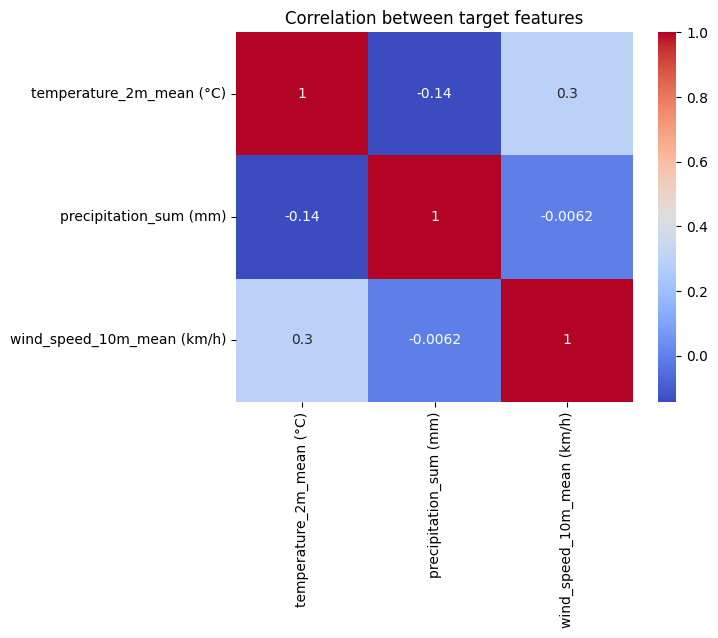

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only the target columns
targets = df[['temperature_2m_mean (°C)', 'precipitation_sum (mm)', 'wind_speed_10m_mean (km/h)']]

# Calculate correlation matrix
corr_matrix = targets.corr()

# Display correlation matrix
print(corr_matrix)

# Optional: visualize with heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation between target features")
plt.show()

Based on the correlation analysis between the target variables (`temperature_2m_mean`, `precipitation_sum`, and `wind_speed_10m_mean`), we observed relatively low correlation among them. This suggests that each target is influenced by different features to a significant extent.

As a result, we will create **three separate regression models**, each dedicated to predicting one of the target variables. For each model, we will focus on selecting the top features that are most strongly correlated with the specific target, in order to improve accuracy and interpretability.

##### Temperature model

In [10]:
# Data of Temperature model

# --- Step 1: Select 4 input features (X) ---
X_wind = df[temp_features]

# --- Step 2: Select 3 target variables (Y) ---
Y_wind = df['temperature_2m_mean (°C)']

# Split data into training and testing sets (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_wind, Y_wind, test_size=0.2, random_state=42
)

# Scale input features to range [-1, 1]
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_temp_train_scaled = xscaler.fit_transform(X_train)
X_temp_test_scaled = xscaler.transform(X_test)

# Scale target values to range [-1, 1]
yscaler = MinMaxScaler(feature_range=(-1, 1))

# Reshape target arrays to 2D for the scaler
Y_temp_train_scaled = yscaler.fit_transform(Y_train.values.reshape(-1, 1))
Y_temp_test_scaled = yscaler.transform(Y_test.values.reshape(-1, 1))

In [11]:
import time
import matplotlib.pyplot as plt

# Qiskit circuits & new V2 primitives
from qiskit.circuit.library import PauliFeatureMap, EfficientSU2, ZZFeatureMap
from qiskit.primitives import StatevectorEstimator, StatevectorSampler

# Qiskit‑Machine‑Learning
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_machine_learning.optimizers import L_BFGS_B, COBYLA, ADAM, SPSA
from qiskit_machine_learning.circuit.library import QNNCircuit

In [12]:
# Initialize an array to store evaluations of the objective function during optimization
objective_func_vals = []

# Define the callback function
def callback_graph(*args):
    """
    Universal callback for NeuralNetworkRegressor / SPSA / ADAM, etc.
    It will be called with one of these argument‐patterns:
      - (weights, loss)
      - (nfev, weights, loss)
      - (loss,)
      - (nfev, weights, loss, grad)
    This will extract the loss (the last numeric argument),
    append it to `objective_func_vals`, and print it.
    """
    # find the first float in args (assuming loss is a float)
    loss = None
    for a in args:
        if isinstance(a, float):
            loss = a
    if loss is None:
        # fallback: assume the last arg is loss
        loss = args[-1]
    
    # Store loss
    objective_func_vals.append(loss)   
    iteration = len(objective_func_vals)

    # Print every 10 iterations
    if iteration % 10 == 0:
        print(f"Iteration {iteration:3d} — Loss: {loss:.6f}")

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Iteration  10 — Loss: 0.504180
Iteration  20 — Loss: 0.590855
Iteration  30 — Loss: 0.339214
Iteration  40 — Loss: 0.291415
Iteration  50 — Loss: 0.967649
Iteration  60 — Loss: 0.535375
Iteration  70 — Loss: 0.454936
Iteration  80 — Loss: 0.466290
Training time: 386.6 s


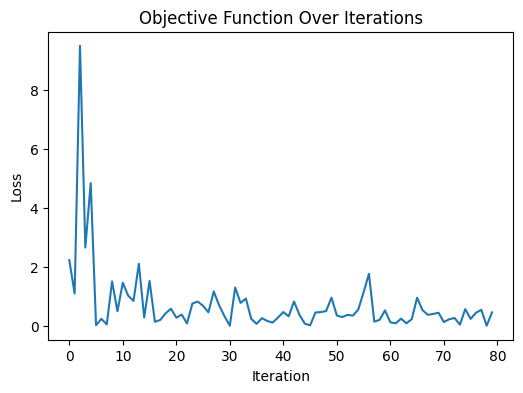

In [16]:
# 1) Use the new V2 Estimator for expectation‑value QNNs
estimator = StatevectorEstimator()

# 2) (Optional) If you ever want a sampling‑based QNN, use StatevectorSampler + SamplerQNN
# sampler = StatevectorSampler()
# qnn = SamplerQNN(circuit=qc, sampler=sampler, input_gradients=True)

# Feature dimension
feature_dim = X_temp_train_scaled.shape[1]

# --- 1. Build the QNN circuit ---

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=1)
ansatz      = EfficientSU2(num_qubits=feature_dim, reps=2, entanglement="linear" , insert_barriers=True)
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# --- 2. Wrap into an EstimatorQNN using the V2 primitive ---

qnn = EstimatorQNN(
    circuit=qc,
    estimator=estimator,
    input_gradients=True           # enable analytic gradients
)

# --- 3. Build the sklearn‑style regressor ---

regressor = NeuralNetworkRegressor(
    neural_network=qnn,
    loss="squared_error",         # mean squared error
    optimizer=SPSA(maxiter=80, callback=callback_graph),
    # callback=callback_graph,       # populates your objective_func_vals list
)

objective_func_vals = []

# --- 4. Train ---

start = time.time()
regressor.fit(X_temp_train_scaled, Y_temp_train_scaled)
elapsed = time.time() - start
print(f"Training time: {elapsed:.1f} s")

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(objective_func_vals)
plt.title("Objective Function Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

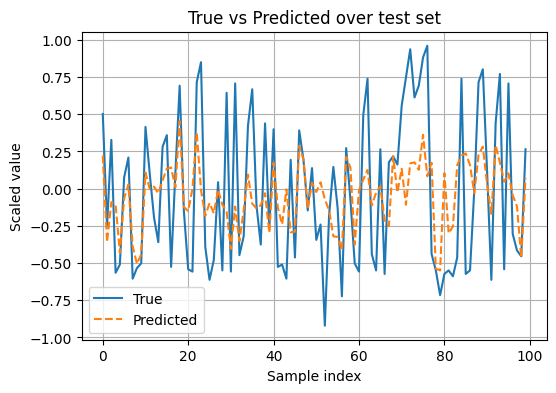

R² Train score: 0.2783
R² Test score: 0.3061


In [17]:
# --- 5. Predict & Evaluate ---

y_pred = regressor.predict(X_temp_test_scaled)
idx = range(len(Y_temp_test_scaled))
plt.plot(idx, Y_temp_test_scaled, label='True')
plt.plot(idx, y_pred, label='Predicted', linestyle='--')
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Scaled value")
plt.title("True vs Predicted over test set")
plt.grid(True)
plt.show()

print(f"R² Train score: {regressor.score(X_temp_train_scaled, Y_temp_train_scaled):.4f}")
print(f"R² Test score: {regressor.score(X_temp_test_scaled, Y_temp_test_scaled):.4f}")

##### Precipitation Model

In [ ]:
# Data of Precipitation model

df = pd.read_csv("./data/Cairo-Weather.csv")


# --- Step 1: Select 4 input features (X) ---
X_wind = df[percipitation_features]

# --- Step 2: Select 3 target variables (Y) ---
Y_wind = df['precipitation_sum (mm)']

# Split data into training and testing sets (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_wind, Y_wind, test_size=0.2, random_state=42
)

# Scale input features to range [-1, 1]
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_wind_train_scaled = xscaler.fit_transform(X_train)
X_wind_test_scaled = xscaler.transform(X_test)

# Scale target values to range [-1, 1]
yscaler = MinMaxScaler(feature_range=(-1, 1))

# Reshape target arrays to 2D for the scaler
Y_wind_train_scaled = yscaler.fit_transform(Y_train.values.reshape(-1, 1))
Y_wind_test_scaled = yscaler.transform(Y_test.values.reshape(-1, 1))

##### Wind Speed Model

In [ ]:
# Data of Wind Speed model

df = pd.read_csv("./data/Cairo-Weather.csv")


# --- Step 1: Select 4 input features (X) ---
X_wind = df[percipitation_features]

# --- Step 2: Select 3 target variables (Y) ---
Y_wind = df['wind_speed_10m_mean (km/h)']

# Split data into training and testing sets (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_wind, Y_wind, test_size=0.2, random_state=42
)

# Scale input features to range [-1, 1]
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_wind_train_scaled = xscaler.fit_transform(X_train)
X_wind_test_scaled = xscaler.transform(X_test)

# Scale target values to range [-1, 1]
yscaler = MinMaxScaler(feature_range=(-1, 1))

# Reshape target arrays to 2D for the scaler
Y_wind_train_scaled = yscaler.fit_transform(Y_train.values.reshape(-1, 1))
Y_wind_test_scaled = yscaler.transform(Y_test.values.reshape(-1, 1))